_version log: Once again making nice plots for poster_

In [10]:
import FTIR_functions as FTIR
import numpy as np
from scipy import interpolate as spinter
from matplotlib import pyplot as plt, patches

In [11]:
###################CREATING AN EXPECTED SPECTRUM USING MANUFACURER DATA##################

manta_data = FTIR.import_normalised_csv("mantra_spectrum.csv", 0)
manta_data[:,0] = FTIR.recip(manta_data[:,0]*1e-3) #convert nm to THz
manta_function = spinter.interp1d(manta_data[:,0], manta_data[:,1], fill_value= np.nan, bounds_error= False)

purple_data = FTIR.import_normalised_csv("PV320_spectrum.csv", 0)
purple_data[:,0] = FTIR.recip(purple_data[:,0]*1e-3) #convert nm to THz
purple_function = spinter.interp1d(purple_data[:,0], purple_data[:,1], fill_value= np.nan, bounds_error= False)

ir_data = FTIR.import_normalised_csv("SLS201L_spectrum.csv", 1)
ir_data[:,0] = FTIR.recip(ir_data[:,0]*1e-3) #convert nm to THz
ir_function = spinter.interp1d(ir_data[:,0], ir_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

big_data = FTIR.import_normalised_csv("SLS303_spectrum.csv", 1)
big_data[:,0] = FTIR.recip(big_data[:,0]*1e-3) #convert nm to THz
big_function = spinter.interp1d(big_data[:,0], big_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

def camera_function(x, camera):
        return (manta_function(x)**(camera == "manta") *
                purple_function(x)**(camera == "purple"))


def manufacturers_function(x, source, camera):
        return (ir_function(x)**(source == "ir") * #source_function if true, 1 if false. I'm kinda proud of this. I think it's a neat solution.
                big_function(x)**(source == "big") *
                manta_function(x)**(camera == "manta") *
                purple_function(x)**(camera == "purple"))

def spectral_responce_normalisation(amplitude, frequencies, source, camera):
        percentagediff = (manufacturers_function(frequencies[:-1], source, camera) - amplitude[:-1]) /amplitude[:-1]
        scaling_factor = np.nanpercentile(percentagediff[percentagediff != -1], 10) +1#re-scale to fit

        if np.isnan(scaling_factor): #This is not equivelent to scaling_factor == np.nan??
                print("WARNING! Could not fit spectrum to manufacturer data.")
        else:
                amplitude *= np.nanpercentile(percentagediff[percentagediff != -1], 10) +1#re-scale to fit

        normalised_amplitude = amplitude / camera_function(frequencies, camera) #factor in the camera sensitivity
        return normalised_amplitude

In [12]:
################MAIN###################

def process_data(source, run, camera, file_type, theta= None, delay_line_delta= 2, zero_padding= 1, apodization_function= None, dead_pixels= 0, autopick_interferogram= True):

    if camera == "manta":
        pixel_pitch = 9.9 #um
    elif camera == "xeva":
        pixel_pitch = 20 #um
    elif camera == "purple":
        pixel_pitch = 48.5 #um
    elif camera == "pyro":
        pixel_pitch = 80 #um
    else:
        raise ValueError(camera + " is not a valid camera.")

    fringes, beamA, beamB, background = FTIR.import_standard_photo(source, run, file_type)
    fringes_processed, nofringes = FTIR.bg_subtract(fringes, beamA, beamB, background, dead_pixels= dead_pixels)
    fringes_averaged, maximums, maximums_offsets = FTIR.average_interferogram(fringes_processed)
    reference, reference_processed, reference_averaged, reference_offset, reference_nofringes = FTIR.pick_centered_interferogram(maximums_offsets, fringes, fringes_processed, fringes_averaged, nofringes, maximums, autopick= autopick_interferogram)
    reference_sliced, reference_FT1D, reference_FT2D, phi = FTIR.FFT2D_slice_interferogram(reference_processed, pixel_pitch)
    reference_sliced = np.fft.fftshift(reference_sliced) #TO DO: FIX PHASE ERROR.
    reference_maximum, _ = FTIR.estimate_best_S2N(reference_sliced)
    reference_zeropadded = FTIR.zero_pad(reference_sliced, zero_padding)
    reference_apodized = FTIR.apodization(reference_zeropadded, reference_maximum, function= apodization_function, L= len(reference_sliced), zero_padding= zero_padding)
    if theta == None:
        theta = FTIR.delay_line_angle(fringes_averaged, maximums, delay_line_delta, pixel_pitch, delay_line_bounds= [2,-1])
    amplitude, corrected_wavelengths, corrected_frequencys = FTIR.spectralFFT(reference_apodized, theta, pixel_pitch)

    normalised_amplitude = spectral_responce_normalisation(amplitude, corrected_frequencys, source, camera)
    
    return reference_processed, reference_FT2D, reference_apodized, reference_maximum, corrected_wavelengths, amplitude, phi


In [13]:
interferogram2D, FFT2D, interferogram1D, maximum, wavelengths, amplitude, phi = process_data("ir", "6", "manta", ".tif", delay_line_delta= 1, zero_padding= 2, apodization_function= ["boxcar"], autopick_interferogram= False, theta= np.deg2rad(6/60))
_, _, interferogram1Dapodized, _, _, _, _ = process_data("ir", "6", "manta", ".tif", delay_line_delta= 1, zero_padding= 2, apodization_function= ["blackmann-harris"], autopick_interferogram= False)
boxcar = FTIR.apodization(interferogram= np.ones(len(interferogram1D)), function= ["boxcar"], max_index= maximum, L= len(interferogram1D)//2, zero_padding= 2)
boxcarFFT = FTIR.apodization(function= ["boxcar"], L= 850, zero_padding= 1000/850)
boxcarFFT = np.real(np.fft.fftshift(-np.fft.fft(boxcarFFT -1, norm= "forward"))) #The center of the function is not at zero so the phase is shifted. I fudged it to make it look right.
blackmann_harris = FTIR.apodization(interferogram= np.ones(len(interferogram1Dapodized)), function= ["blackmann-harris"], max_index= maximum, L= len(interferogram1D)//2, zero_padding= 2)
blackmannFFT = FTIR.apodization(function= ["blackmann-harris"], L= 160, zero_padding= 1000/160)
blackmannFFT = np.abs(np.fft.fftshift(np.fft.fft(blackmannFFT, norm= "forward")[1:]))

interferogram1D /= np.max(interferogram1D)
interferogram1Dapodized /= np.max(interferogram1Dapodized)

interferogram1D = np.array([np.nan if x == 0 else x for x in interferogram1D])
interferogram1Dstart = np.argwhere(~np.isnan(interferogram1D))[0]
interferogram1Dend = np.argwhere(~np.isnan(interferogram1D))[-1]
interferogram1Dindex = np.arange(len(interferogram1D)) -interferogram1Dstart

pixel_pitch = 9.9 #um

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\series.py:1021: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.asarray(values, dtype=dtype)
c:\Users\syf83691\OneDrive - Science and Technology Facilities Council\Documents\python\git_projects\THz-interferometry\interferometry\FTIR_functions.py:301: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["max"].interpolate(inplace=True)
C:\User

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\syf83691\AppData\Local\Temp\ipykernel_8072\4192526721.py:47: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  inset2.set(xticks= [], yticks= [], xlim= (450, 550), ylim= (boxcarFFT.min() -0.1*boxcarFFT.max(), 1.3*boxcarFFT.max()))


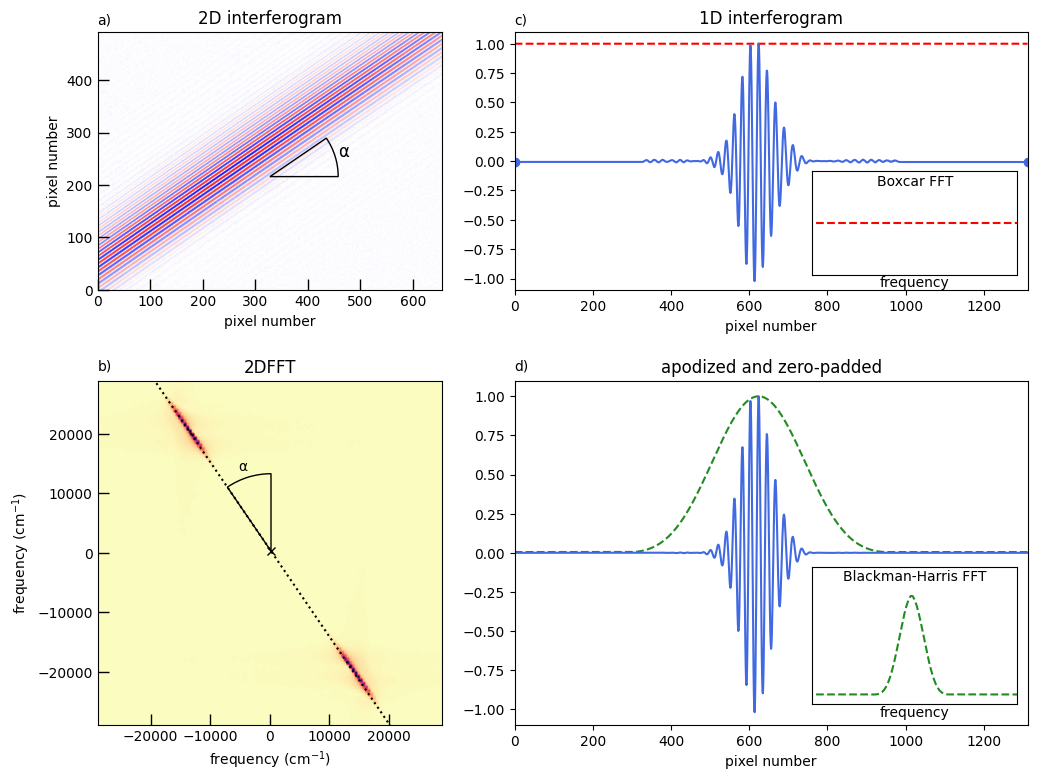

In [14]:
nyquist = 0.5/pixel_pitch /2/np.sin(np.deg2rad(6/60)) *1e4 # [niquist in um^-1] * [compensate for angle] * [convert to cm^-1]

x_center = 0.5/FFT2D.shape[1] /pixel_pitch /2/np.sin(np.deg2rad(6/60)) *1e4 # [um^-1] * [compensate for angle] * [convert to cm^-1]
y_center = 0.5/FFT2D.shape[0] /pixel_pitch /2/np.sin(np.deg2rad(6/60)) *1e4 # [um^-1] * [compensate for angle] * [convert to cm^-1]
line_x = np.fft.fftshift(np.fft.fftfreq(len(interferogram1D), 0.5/nyquist)) *np.cos(phi) +x_center
line_y = np.fft.fftshift(np.fft.fftfreq(len(interferogram1D), 0.5/nyquist)) *np.sin(phi) +y_center

manta_aspect_ratio = interferogram2D.shape[1] /interferogram2D.shape[0]

fig = plt.figure(figsize=(12, 9))
grid = fig.add_gridspec(2, 2, height_ratios= [1, manta_aspect_ratio], width_ratios= [1,1.3], hspace= 0.3 ,wspace= 0.05)
axs = grid.subplots()
axs = axs.flatten() #makes it easier to work with

[ax.tick_params(direction= "in", length= 8, width= 1) for ax in [axs[0], axs[2]]]
[ax.set_anchor("NW") for ax in axs]
letter_labels= ["a)","c)","b)","d)"]
[ax.text(0, 1.03, letter_labels[n], transform= ax.transAxes) for n, ax in enumerate(axs)]


axs[0].imshow(interferogram2D, cmap='bwr', origin= "lower")
axs[0].set(title= "2D interferogram", xlabel= "pixel number", ylabel= "pixel number")
# Create the sector (wedge) patch
wedge_patch = patches.Wedge((0.5*interferogram2D.shape[1], 0.5*interferogram2D.shape[0] -30), 130.0, theta1= 0, theta2= 90 -np.abs(np.rad2deg(phi)), edgecolor='k', facecolor= "None")
axs[0].add_patch(wedge_patch)
#label the patch
axs[0].annotate("α", xy=(0.7, 0.5), xycoords='axes fraction', fontsize=12, ha='left', va='bottom')


axs[2].imshow(np.abs(FFT2D), origin= "lower", extent= (-nyquist, nyquist, -nyquist, nyquist), cmap= "magma_r")
axs[2].plot(x_center, y_center, marker= "x", color= "k", label= "center point")
axs[2].plot(line_x, line_y, color= "k", label= "largest signal", linestyle= ":")
axs[2].set(xlim= (-0.2*nyquist, 0.2*nyquist), ylim= (-0.2*nyquist, 0.2*nyquist), title= "2DFFT", xlabel= "frequency (cm$^{-1}$)", ylabel= "frequency (cm$^{-1}$)")
# Create the sector (wedge) patch
wedge_patch = patches.Wedge((x_center, y_center), 13000.0, theta1= 90, theta2= 180 -np.abs(np.rad2deg(phi)), edgecolor='k', facecolor= "None")
axs[2].add_patch(wedge_patch)
#label the patch
axs[2].annotate("α", xy=(0.41, 0.73), xycoords='axes fraction', ha='left', va='bottom')

axs[1].plot(interferogram1Dindex, boxcar, linestyle= "--", color= "red")
axs[1].plot(interferogram1Dindex, interferogram1D, color= "royalblue")
axs[1].plot(interferogram1Dindex[interferogram1Dstart], interferogram1D[interferogram1Dstart], linestyle= "None", marker= "o",color= "royalblue")
axs[1].plot(interferogram1Dindex[interferogram1Dend], interferogram1D[interferogram1Dend], linestyle= "None", marker= "o",color= "royalblue")
axs[1].set(xlim= (interferogram1Dindex[0], interferogram1Dindex[-1]), ylim= (-1.1, 1.1), title= "1D interferogram", xlabel= "pixel number")
inset2 = axs[1].inset_axes([0.58, 0.06, 0.4, 0.4])
inset2.plot(boxcarFFT, linestyle= "--", color= "red")
inset2.set(xticks= [], yticks= [], xlim= (450, 550), ylim= (boxcarFFT.min() -0.1*boxcarFFT.max(), 1.3*boxcarFFT.max()))
inset2.set_title("Boxcar FFT", y=1, pad=-10, fontsize= 10)
inset2.set_xlabel("frequency", labelpad= 1, fontsize= 10)


axs[3].plot(interferogram1Dindex, blackmann_harris, linestyle= "--", color= "forestgreen")
axs[3].plot(interferogram1Dindex, interferogram1Dapodized, color= "royalblue")
axs[3].set(xlim= (interferogram1Dindex[0], interferogram1Dindex[-1]), ylim= (-1.1, 1.1), title= "apodized and zero-padded", xlabel= "pixel number")
inset3 = axs[3].inset_axes([0.58, 0.06, 0.4, 0.4])
inset3.plot(blackmannFFT, linestyle= "--", color= "forestgreen")
inset3.set(xticks= [], yticks= [], xlim= (450, 550), ylim= (blackmannFFT.min() -0.1*blackmannFFT.max(), 1.3*blackmannFFT.max()))
inset3.set_title("Blackman-Harris FFT", y=1, pad=-10, fontsize= 10)
inset3.set_xlabel("frequency", labelpad= 1, fontsize= 10)

plt.show()

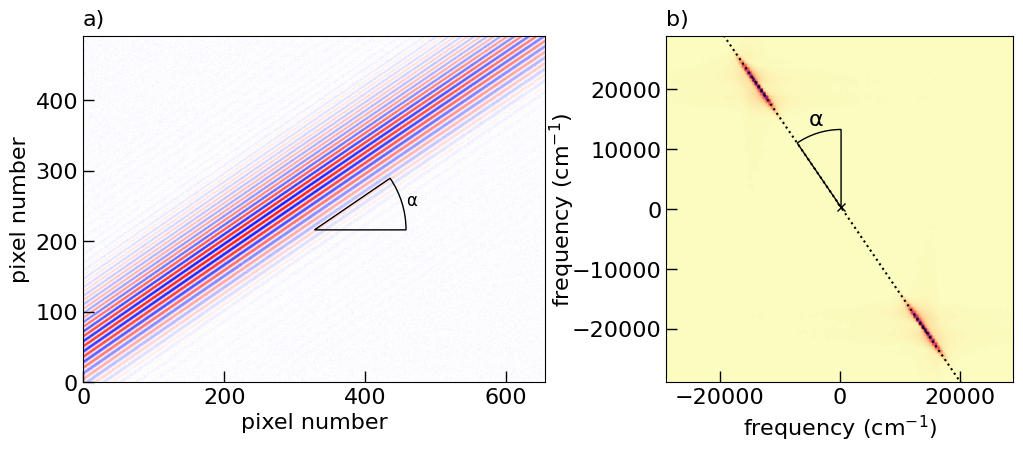

In [15]:
plt.rcParams.update({'font.size':16})

fig = plt.figure(figsize=(12, 10))
grid = fig.add_gridspec(1, 2, width_ratios= [manta_aspect_ratio, 1] ,wspace= 0.3)
axs = grid.subplots()
axs = axs.flatten() #makes it easier to work with

[ax.tick_params(direction= "in", length= 8, width= 1) for ax in axs]
[ax.set_anchor("NW") for ax in axs]
letter_labels= ["a)","b)"]
[ax.text(0, 1.03, letter_labels[n], transform= ax.transAxes) for n, ax in enumerate(axs)]


axs[0].imshow(interferogram2D, cmap='bwr', origin= "lower")
axs[0].set(xlabel= "pixel number", ylabel= "pixel number")
# Create the sector (wedge) patch
wedge_patch = patches.Wedge((0.5*interferogram2D.shape[1], 0.5*interferogram2D.shape[0] -30), 130.0, theta1= 0, theta2= 90 -np.abs(np.rad2deg(phi)), edgecolor='k', facecolor= "None")
axs[0].add_patch(wedge_patch)
#label the patch
axs[0].annotate("α", xy=(0.7, 0.5), xycoords='axes fraction', fontsize=12, ha='left', va='bottom')


axs[1].imshow(np.abs(FFT2D), origin= "lower", extent= (-nyquist, nyquist, -nyquist, nyquist), cmap= "magma_r")
axs[1].plot(x_center, y_center, marker= "x", color= "k", label= "center point")
axs[1].plot(line_x, line_y, color= "k", label= "largest signal", linestyle= ":")
axs[1].set(xlim= (-0.2*nyquist, 0.2*nyquist), ylim= (-0.2*nyquist, 0.2*nyquist), xlabel= "frequency (cm$^{-1}$)")
axs[1].set_ylabel("frequency (cm$^{-1}$)", labelpad= -4)
# Create the sector (wedge) patch
wedge_patch = patches.Wedge((x_center, y_center), 13000.0, theta1= 90, theta2= 180 -np.abs(np.rad2deg(phi)), edgecolor='k', facecolor= "None")
axs[1].add_patch(wedge_patch)
#label the patch
axs[1].annotate("α", xy=(0.41, 0.73), xycoords='axes fraction', ha='left', va='bottom')

plt.show()